In [27]:
import numpy as np
from homography import pyrs12, spaces
import cv2, h5py, deproject, HandShapeAnalysis
import matplotlib.pyplot as plt

In [28]:
def plt_imsize(image,size=(20,20)):
    fig1 = plt.figure(figsize=size) # create a figure with the default size 
    ax1 = fig1.add_subplot(1,1,1) 
    ax1.imshow(image, interpolation='none')
    plt.show()

In [29]:
ls ../recording_data

1_move_down_not.hdf5   2_move_down_yes.hdf5   4_move_down_yes.hdf5
1_move_down_yes.hdf5   2_move_right_no.hdf5   4_move_left_yes.hdf5
1_move_right_not.hdf5  2_move_right_yes.hdf5  4_move_right_yes.hdf5
1_move_right_yes.hdf5  2_tap.hdf5             backup/
1_tap.hdf5             2_zoomin_yes.hdf5
2_move_down_no.hdf5    2_zoomout_yes.hdf5


In [30]:
one = h5py.File('../recording_data/1_move_right_not.hdf5', 'r')

In [31]:
org = one['pcl_center'][...]
mat = one['trans_matrix'][...]

In [32]:
analyser = HandShapeAnalysis.Depth2Finger(org, mat)
analyser.set_show(debug = True, finger_point_image = True, hull_image = True, detected_defect = True, cluster_point= True)

In [33]:
analyser.renew(one['depth'][13])

In [34]:
hall = np.array([[458,219],[457,228],[456,230],[453,233],[444,233],[439,229],[350,152],[349,151],[348,149],[341,123],[341,112],[342,96],[346,80],[347,77],[349,73],[370,36],[393,0],[410,0],[413,1],[423,22],[443,95],[447,113],[448,118],[454,168],[458,206]])

In [35]:
vector = np.array([[143],[141],[139],[138],[137],[135],[ 76],[ 75],[ 73],[ 59],[ 58],[ 56],[ 48],[ 46],[ 42],[ 20],[ 0],[212],[210],[200],[176],[168],[166],[154],[144]])

In [36]:
hall.shape

(25, 2)

In [37]:
vector.shape

(25, 1)

In [38]:
point_vector = np.concatenate((hall, vector),axis = 1)

In [39]:
point_vector[0][:2]

array([458, 219])

In [40]:
def clustering_by_distinct(point):
    result = []
    point = point.tolist()
    while(len(point) >= 2):
        first = point.pop(0)
        dist = distance(np.asarray(first)[:2], np.asarray(point)[:,:2])
        group = np.concatenate((np.asarray(point)[dist], np.asarray(first).reshape(1,3))).tolist()
        #group = all the point that close to first point
        remain = np.asarray(point)[np.logical_not(dist)].tolist()
        point, final_cluster = check_closePoint_list(remain, group)
        result.append(final_cluster.tolist())
        
    if(len(point)==1):
        result.append([point.pop(0)])
    mean = []
    for i in result:
        mean.append(np.mean(np.array(i),axis =0).astype(np.int32))
    return np.asarray(mean)

def check_closePoint_list(points, cluster):
    have_close = False
    new_cluster = np.empty((0,3),dtype = np.int32)
    if(len(points)==0):##There is nothing to check if given points is empty, just return it
        return points, cluster
    for p in cluster:
        dist = distance(np.asarray(p)[:2], np.asarray(points)[:,:2])
        have_close = np.sum(dist) == 1##check if there is new point added in
        new_cluster = np.concatenate((new_cluster, np.asarray(points)[dist]),axis = 0)
        points = np.asarray(points)[np.logical_not(dist)].tolist()
        if(len(points)==0):
            break
    if have_close:##if there is new point added in, need to check if new point link to other point
        np.concatenate((cluster, check_closePoint_list(points,new_cluster)),axis = 0)
    else:
        return points, np.concatenate((cluster,new_cluster))

def distance(p1, p2, threshold=15):
    p1 = np.array(p1)
    p2 = np.array(p2)
    result = np.sum(np.power(p2-p1,2),axis =1)
    return  result < threshold*threshold

In [41]:
r = clustering_by_distinct(point_vector)

In [42]:
r

array([[452, 225, 139],
       [349, 150,  74],
       [341, 117,  58],
       [342,  96,  56],
       [347,  76,  45],
       [370,  36,  20],
       [393,   0,   0],
       [411,   0, 211],
       [423,  22, 200],
       [443,  95, 176],
       [447, 115, 167],
       [454, 168, 154]], dtype=int32)

In [43]:
r

array([[452, 225, 139],
       [349, 150,  74],
       [341, 117,  58],
       [342,  96,  56],
       [347,  76,  45],
       [370,  36,  20],
       [393,   0,   0],
       [411,   0, 211],
       [423,  22, 200],
       [443,  95, 176],
       [447, 115, 167],
       [454, 168, 154]], dtype=int32)

In [44]:
r = r[(r[:,0]!=0)&(r[:,1]!=0)]

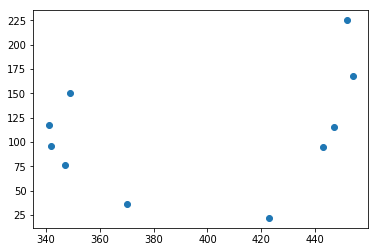

In [45]:
plt.scatter(r[:,0], r[:,1])

In [46]:
r[:,:2].reshape(len(r),1,2)

array([[[452, 225]],

       [[349, 150]],

       [[341, 117]],

       [[342,  96]],

       [[347,  76]],

       [[370,  36]],

       [[423,  22]],

       [[443,  95]],

       [[447, 115]],

       [[454, 168]]], dtype=int32)

In [47]:
colored = cv2.applyColorMap(cv2.convertScaleAbs(one['depth'][13], alpha=0.03), cv2.COLORMAP_JET)

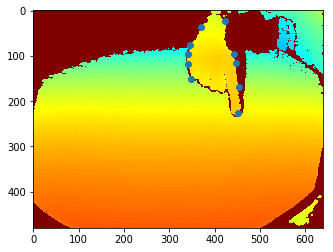

In [48]:
plt.imshow(colored)
plt.scatter(r[:,0], r[:,1])

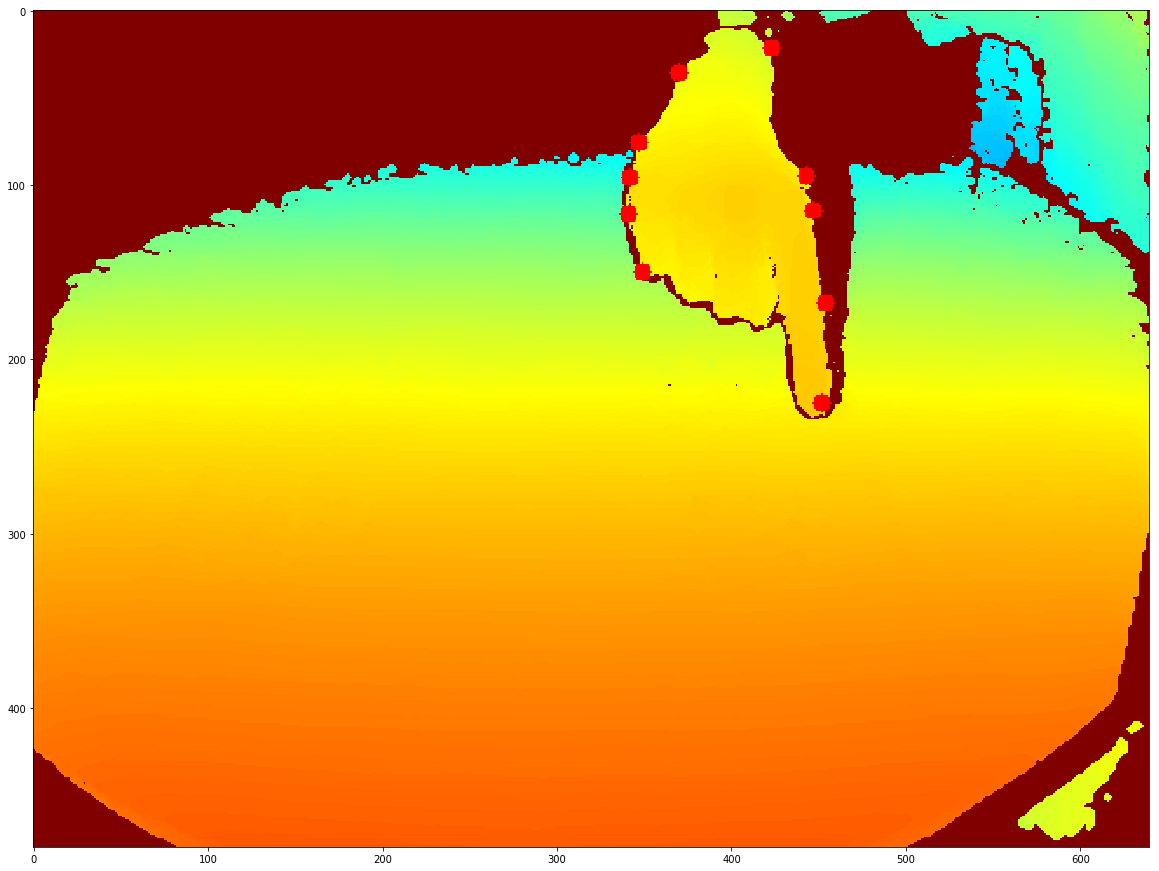

In [49]:
plt_imsize(cv2.drawContours(colored, r[:,:2].reshape(len(r),1,2), -1, (255,0,0), 10))

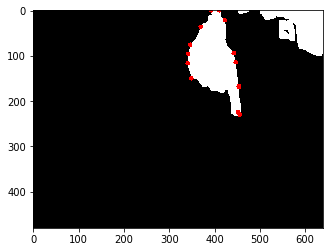

In [50]:
plt.imshow(analyser.cluster_point)